In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import caffe
import cv2
% matplotlib inline
from tools.preprocessing import aspect_resize
from tools.dataset import SPCDataset

ROOT = '/data6/lekevin/cayman'
img_dir = ROOT + '/rawdata'
ALL = ['train', 'val', 'test']
csv_filename = os.path.join(ROOT, 'data', '3', 'data_{}.csv')
dataset = {phase: SPCDataset(csv_filename=csv_filename.format(phase), img_dir=img_dir, phase=phase) for phase in ALL}
test_imgs, lbls = dataset['val'].get_fns()
for phase in dataset:
    print(dataset[phase])

Dataset [test] 1 classes, 196169 images
Dataset [train] 2 classes, 1513 images
Dataset [val] 2 classes, 268 images


# Original Preprocessing
Steps:
1. Convert [0,1] -> [0,255] and 8bit
2. Maintain aspect ratio and resize to 255,255
3. RGB -> BGR
4. HWC -> CHW

Col1:Original Image		Col2:255 Convert	Col3: Aspect Resize	Col4:BGR Convert


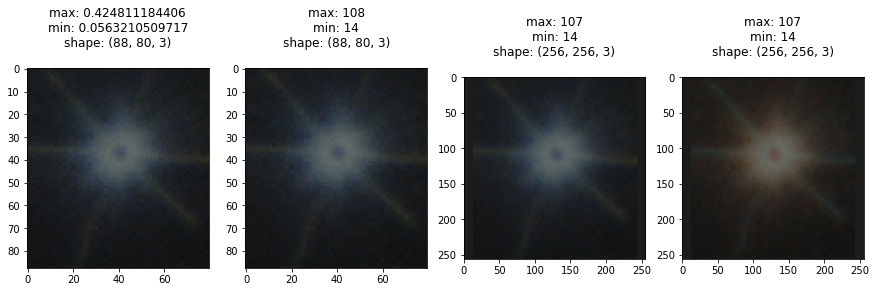

In [16]:
def preprocessing(img):
    img = (img*255).astype(np.uint8)
    img = aspect_resize(img)
    img = img[:,:, (2,1,0)]
    img = np.transpose(img, (2,0,1))
    return img

def debug_img(axarr, index, img):
    try:
        axarr[index].imshow(img)
    except:
        print(img)
    finally:
        axarr[index].set_title('max: {}\nmin: {}\nshape: {}\n'.format(img.max(), img.min(), img.shape))
    
fig, axarr = plt.subplots(1,4, figsize=(15,4))
print('Col1:Original Image\t\tCol2:255 Convert\tCol3: Aspect Resize\tCol4:BGR Convert')
img = caffe.io.load_image(test_imgs[5])
debug_img(axarr, 0, img)

img = (img*255).astype(np.uint8)
debug_img(axarr, 1, img)

img = aspect_resize(img)
debug_img(axarr, 2, img)

img = img[:,:,(2,1,0)]
debug_img(axarr, 3, img)

# 8 Bit Color Conversion Preprocessing
convert_to_8bit -> original script pulled from github using current auto scale method

convert_to_8bit2 -> same script, but using the commented version for the auto scale

Col1: Raw Image,		Col2: 8_bit_convert_1,		Col3: 8_bit_convert_2


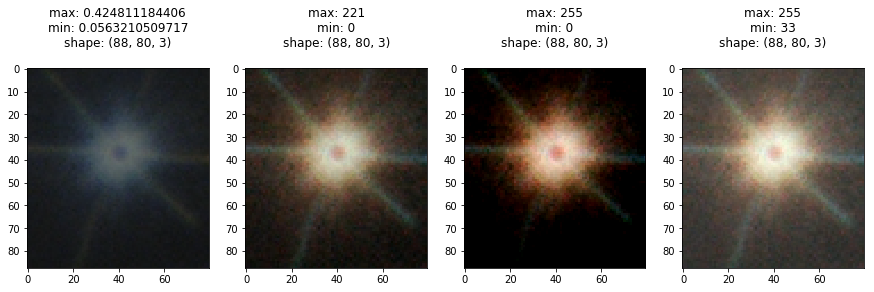

In [21]:
def import_image(filename,raw=False,bayer_pattern=cv2.COLOR_BAYER_RG2RGB):

    # Load and convert image as needed
    img_c = cv2.imread(filename, -1)
    if raw:
        img_c = cv2.cvtColor(img_c,bayer_pattern)

    return img_c

def convert_to_8bit(img,auto_scale=True):

    # Convert to 8 bit and autoscale
    if auto_scale:
        result = np.float32(img)-np.min(img)
        result[result<0.0] = 0.0
        if np.max(img) != 0:
            result = result/np.max(img)

        img_8bit = np.uint8(255*result)
    else:
        img_8bit = np.unit8(img)
    return img_8bit

        
def convert_to_8bit2(img,auto_scale=True):

    # Convert to 8 bit and autoscale
    if auto_scale:

        result = np.float32(img)-np.median(img)
        max_val1 = np.max(img)
        max_val2 = np.max(result)
        result[result < 0] = 0
        result = result/(0.5*max_val1+0.5*max_val2)
        
        bch = result[:,:,0]
        gch = result[:,:,1]
        rch = result[:,:,2]
        b_avg = np.mean(bch)
        g_avg = np.mean(gch)
        r_avg = np.mean(rch)
        avg = np.mean(np.array([b_avg,g_avg,r_avg]))
        #print "R: " + str(r_avg) + ", G: " + str(g_avg) + ", B: " + str(b_avg)
        bch = bch*1.075
        rch = rch*0.975
        gch = gch*0.95
        # bch = bch*avg/b_avg
        # rch = rch*avg/r_avg
        # gch = gch*avg/g_avg
        # b_avg = np.mean(bch)
        # g_avg = np.mean(gch)
        # r_avg = np.mean(rch)
        #print "New R: " + str(r_avg) + ", G: " + str(g_avg) + ", B: " + str(b_avg)
        result[:,:,0] = bch
        result[:,:,1] = gch
        result[:,:,2] = rch

        result = result/np.max(result)
        img_8bit = np.uint8(255*result)
    else:
        img_8bit = np.unit8(img)

    return img_8bit

fig, axarr = plt.subplots(1,4, figsize=(15,4))
print('Col1: Raw Image,\t\tCol2: 8_bit_convert_1,\t\tCol3: 8_bit_convert_2')
img = caffe.io.load_image(test_imgs[5])
debug_img(axarr, 0, img)
img1, lbl = test_imgs[5], lbls[5]
img_c = import_image(img1)
img_8bit = convert_to_8bit(img_c)
debug_img(axarr, 1, img_8bit)
img_8bit = convert_to_8bit2(img_c)
debug_img(axarr, 2, img_8bit)
features = preprocessing(img_c)
debug_img(axarr, 3, features['image'])

# Segmentation

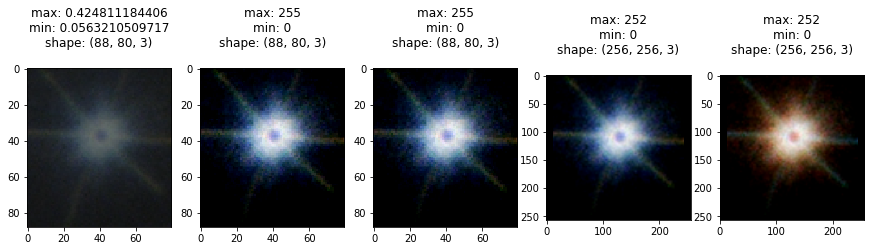

In [20]:
from skimage import morphology, measure, exposure, restoration
from skimage import transform
from skimage.feature import register_translation
from skimage.filters import threshold_otsu, scharr, gaussian
from scipy import ndimage

def make_gaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    output = np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    output = output/np.sum(output)

    return output

def preprocessing(img):
    min_obj_area = 100
    objs_per_roi = 1
    deconv = False
    raw_color = True
    edge_thresh = 2.5

    features = {}
    gray = np.uint8(np.mean(img,2))
    edges_mag = scharr(gray)
    edges_thresh = 2.5*edges_mag
    edges = edges_mag >= edges_thresh
    edges = morphology.closing(edges, morphology.square(3))
    filled_edges = ndimage.binary_fill_holes(edges)
    edges = morphology.erosion(filled_edges, morphology.square(3))
    
    # combine threshold and edge based segmentations
    bw_img2 = edges
    #bw_img = np.pad(bw_img2,1, 'constant')
    bw_img = bw_img2

    # Compute morphological descriptors
    label_img = morphology.label(bw_img,neighbors=8,background=0)
    props = measure.regionprops(label_img,gray)
    
    # clear bw_img
    bw_img = 0*bw_img
    
    props = sorted(props, reverse=True, key=lambda k: k.area) 

    if len(props) > 0:

        # Init mask with the largest area object in the roi
        bw_img = (label_img)== props[0].label
        
        base_area = props[0].area
    
        # use only the features from the object with the largest area
        max_area = 0
        max_area_ind = 0
        avg_area = 0.0
        avg_maj = 0.0
        avg_min = 0.0
        avg_or = 0.0
        avg_count = 0
        
        if len(props) > objs_per_roi:
            n_objs = objs_per_roi
        else:
            n_objs = len(props)
        
        for f in range(0,n_objs):
        
            if props[f].area > min_obj_area:
                bw_img = bw_img + ((label_img)== props[f].label)
                avg_count = avg_count + 1
            
            if f >= objs_per_roi:
                break
        
        # Take the largest object area as the roi area
        # no average
        avg_area = props[0].area
        avg_maj = props[0].major_axis_length
        avg_min = props[0].minor_axis_length
        avg_or = props[0].orientation
        
        
        # Check for clipped image
        if np.max(bw_img) == 0:
            bw = bw_img
        else:
            bw = bw_img/np.max(bw_img)
            
        clip_frac = float(np.sum(bw[:,1]) +
                np.sum(bw[:,-2]) +
                np.sum(bw[1,:]) +
                np.sum(bw[-2,:]))/(2*bw.shape[0]+2*bw.shape[1])
        features['clipped_fraction'] = clip_frac

        # Save simple features of the object
        features['area'] = avg_area
        features['minor_axis_length'] = avg_min
        features['major_axis_length'] = avg_maj
        if avg_maj == 0:
            features['aspect_ratio'] = 1
        else:
            features['aspect_ratio'] = avg_min/avg_maj
        features['orientation'] = avg_or
        
        # print "Foreground Objects: " + str(avg_count)

    else:

        features['clipped_fraction'] = 0.0

        # Save simple features of the object
        features['area'] = 0.0
        features['minor_axis_length'] = 0.0
        features['major_axis_length'] = 0.0
        features['aspect_ratio'] = 1
        features['orientation'] = 0.0
    
    # Masked background with Gaussian smoothing, image sharpening, and
    # reduction of chromatic aberration

    # mask the raw image with smoothed foreground mask
    blurd_bw_img = gaussian(bw_img,3)
    img[:,:,0] = img[:,:,0]*blurd_bw_img
    img[:,:,1] = img[:,:,1]*blurd_bw_img
    img[:,:,2] = img[:,:,2]*blurd_bw_img

    # Make a guess of the PSF for sharpening
    psf = make_gaussian(5, 3, center=None)

    # sharpen each color channel and then reconbine
    
    
    if np.max(img) == 0:
        img = np.float32(img)
    else:
        img = np.float32(img)/np.max(img)
    
    if deconv:
            
        img[img == 0] = 0.0001
        img[:,:,0] = restoration.richardson_lucy(img[:,:,0], psf, 7)
        img[:,:,1] = restoration.richardson_lucy(img[:,:,1], psf, 7)
        img[:,:,2] = restoration.richardson_lucy(img[:,:,2], psf, 7)

    # Estimate color channel shifts and try to align.
    # this works for most images but some still retain and offset.
    # need to figure out why...
    # r_shift, r_error, r_diffphase = register_translation(img[:,:,1], img[:,:,2],1)
    # b_shift, b_error, b_diffphase = register_translation(img[:,:,1], img[:,:,0],1)

    # # this swap of values is needed for some reason
    # if r_shift[0] < 0 and r_shift[1] < 0:
       # r_shift = -r_shift

    # if b_shift[0] < 0 and b_shift[1] < 0:
       # b_shift = -b_shift

    # r_tform = transform.SimilarityTransform(scale=1,rotation=0,translation=r_shift)
    # img[:,:,2] = transform.warp(img[:,:,2],r_tform)

    # b_tform = transform.SimilarityTransform(scale=1,rotation=0,translation=b_shift)
    # img[:,:,0] = transform.warp(img[:,:,0],b_tform)

    # Rescale image to uint8 0-255
    img[img < 0] = 0
    
    if np.max(img) == 0:
        img = np.uint8(255*img)
    else:
        img = np.uint8(255*img/np.max(img))
        
    features['image'] = img
    features['binary'] = 255*bw_img
    return features

fig, axarr = plt.subplots(1,5, figsize=(15,4))
img = caffe.io.load_image(test_imgs[5])
debug_img(axarr, 0, img)
img = convert_to_8bit2(img) # 8 bit conversion
debug_img(axarr, 1, img)
features = preprocessing(img)
debug_img(axarr, 2, features['image'])
img = aspect_resize(img)
debug_img(axarr, 3, img)
img = img[:,:,(2,1,0)]
debug_img(axarr, 4, img)

# Validate LMDB Preprocessing
## Original Process

Loading /data6/lekevin/cayman/data/2/val.LMDB
LMDB successfully loaded
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
(247.0, 0.0, (3, 227, 227))
(124.0, -123.0, (3, 227, 227))
[[[-104.  -99.  -95. ...  -98. -104.  -99.]
  [-102. -104. -103. ...  -99. -102. -104.]
  [-102. -100.  -93. ... -103. -102. -101.]
  ...
  [-104. -104. -102. ... -102.  -96. -100.]
  [-104. -104. -101. ...  -98. -101.  -98.]
  [-104. -104. -102. ... -103.  -98.  -97.]]

 [[-117. -111. -110. ... -115. -117. -116.]
  [-115. -113. -115. ... -117. -114. -117.]
  [-111. -113. -109. ... -115. -115. -116.]
  ...
  [-117. -117. -114. ... -116. -108. -113.]
  [-117. -117. -116. ... -114. -

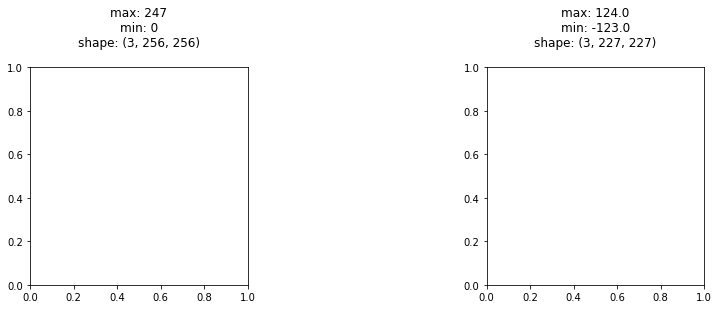

In [6]:
# Load LMDB
images, labels = dataset['val'].load_lmdb()

# Conduct preprocessing step after loading lmdb
def prep_image(img):
    img = img.astype (float)[:, 14:241, 14:241]  # center crop (img is in shape [C,X,Y])
    print(img.max(), img.min(), img.shape)
    img -= np.array ([104., 117., 123.]).reshape ((3, 1, 1))  # demean (same as in trainval.prototxt
    print(img.max(), img.min(), img.shape)
    return img

# Check image properties
fig, axarr = plt.subplots (1,2, figsize=(15,4))
debug_img(axarr,0, images[0])
preprocessed_img = prep_image(images[0])
debug_img(axarr,1, preprocessed_img)

(255.0, 0.0, (3, 227, 227))
(132.0, -123.0, (3, 227, 227))
[[[-104. -104. -104. ... -104. -104. -104.]
  [-104. -104. -104. ... -104. -104. -104.]
  [-104. -104. -104. ... -104. -104. -104.]
  ...
  [-104. -104. -104. ... -104. -104. -104.]
  [-104. -104. -104. ... -104. -104. -104.]
  [-104. -104. -104. ... -104. -104. -104.]]

 [[-117. -117. -117. ... -117. -117. -117.]
  [-117. -117. -117. ... -117. -117. -117.]
  [-117. -117. -117. ... -117. -117. -117.]
  ...
  [-117. -117. -117. ... -117. -117. -117.]
  [-117. -117. -117. ... -117. -117. -117.]
  [-117. -117. -117. ... -117. -117. -117.]]

 [[-123. -123. -123. ... -123. -123. -123.]
  [-123. -123. -123. ... -123. -123. -123.]
  [-123. -123. -123. ... -123. -123. -123.]
  ...
  [-123. -123. -123. ... -123. -123. -123.]
  [-123. -123. -123. ... -123. -123. -123.]
  [-123. -123. -123. ... -123. -123. -123.]]]


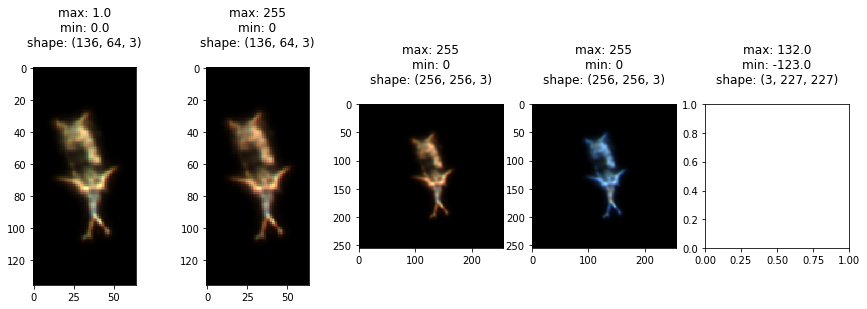

In [9]:
# Repeat original process with 8 bit conversion
fig, axarr = plt.subplots(1,5, figsize=(15,4))
#img = caffe.io.load_image(test_imgs[0]) # cayman image
img = caffe.io.load_image('SPCBench-1487269545-001248-001-248-2100-64-136-.png') # SPC image
debug_img(axarr, 0, img)
img = convert_to_8bit2(img) # 8 bit conversion
debug_img(axarr, 1, img)
img = aspect_resize(img)
debug_img(axarr, 2, img)
img = img[:,:,(2,1,0)]
debug_img(axarr, 3, img)
img = np.transpose(img, (2,0,1))

# augmentation in lmdb
img = prep_image(img) # center crop and demean the image
debug_img(axarr, 4, img)

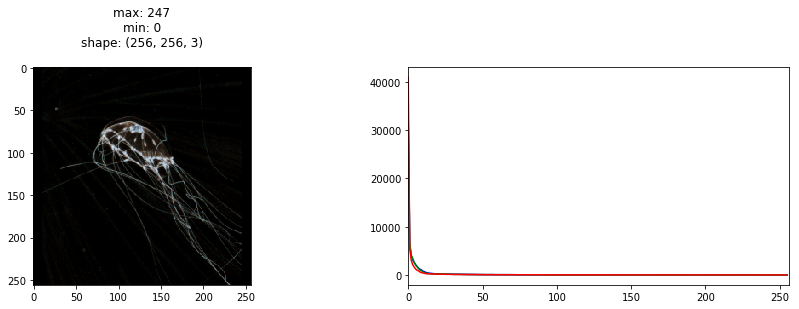

In [8]:
fig, axarr = plt.subplots (1,2, figsize=(15,4))
pre_img = np.transpose(images[0], (2,1,0))
debug_img(axarr,0, pre_img)

for i, col in enumerate(['b', 'g', 'r']):
    histr = cv2.calcHist([pre_img], [i], None, [256], [0,256])
    plt.plot(histr, color = col)
    plt.xlim([0,256])
    
plt.show()